In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import comet_ml
from comet_ml import Experiment

In [3]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger

In [4]:
from manifoldembedder import *

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})

In [6]:
file_dict = {'train':'/nobackup/users/sangeon/datasets/jets/jet_pair_train_temp.pt', 'val':'/nobackup/users/sangeon/datasets/jets/jet_pair_val_temp.pt','test':'/nobackup/users/sangeon/datasets/jets/jet_pair_test_temp.pt', 'predict':'/nobackup/users/sangeon/datasets/jets/concat_predict_temp.pt'}

In [7]:
#file_dict = {'train':'/nobackup/users/sangeon/datasets/jets/concat_triplet_train_temp.pt', 'val':'/nobackup/users/sangeon/datasets/jets/concat_triplet_val_temp.pt','test':'/nobackup/users/sangeon/datasets/jets/concat_triplet_test_temp.pt', 'predict':'/nobackup/users/sangeon/datasets/jets/concat_predict_temp.pt'}

In [8]:
#dataset = torch.load('/nobackup/users/sangeon/datasets/jets/concat_train_temp.pt')

In [9]:
#jetpair_train = DataLoader(dataset, batch_size=10000,shuffle=True,num_workers=4)

In [10]:
jet_dm = JetDataModule(file_dict,1000)
#jettriplet_dm = 

In [11]:
#emd = np.array([])
#for i,(_,_,dist) in enumerate(jetpair_train):
#    if i>100:
#        break
#    emd = np.concatenate([emd,dist.data.numpy()])

In [12]:
#emd

In [13]:
#plt.hist(emd)

In [14]:
#d_model, nhead, num_encoder_layers, num_decoder_layers, embed_dim, max_seq_length, pos_dropout, trans_dropout, layer_widths

In [15]:
#lr, npart, embed_dim, hidden_size, num_rnn_layers, layer_widths

In [16]:
#model = ManifoldEmbedder("jets",2,"Transformer", 0.00054607179632484, 32, 2 , 2, 2, 2, 8, 0.7,0.7, [500,300,10])
#model = ManifoldEmbedder("jets",3,"Transformer", 0.00054607179632484, 16, 4 , 2, 2, 2, 8, 0.7,0.7, [500,300,10])
model = ManifoldEmbedder("jets",2,"Transformer", 0.00054607179632484, 16, 4 , 2, 2, 2, 8, 0.7,0.7, [500,300,10])

#model = ManifoldEmbedder("jets",3, "Transformer", 0.00054607179632484, 32, 8 , 4, 4, 2, 8, 0.5,0.5, [1000,500,10])
#model = ManifoldEmbedder("jets","MLP", 1e-2, 8, 2, [100,100,100,80,40,20,10])
#model = ManifoldEmbedder('jets',3,"GRU", 0.02089296130854041, 8, 2, 40, 40, [1000,500,10])


In [17]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="CkkrVkSk6Vr2WKlbXIzlkhNlE",
    project_name="metricembedder",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sangeonpark/metricembedder/e57fb5d95b8e40b2b3dbd6047afd652c



In [18]:
comet_logger = CometLogger(
    api_key="CkkrVkSk6Vr2WKlbXIzlkhNlE",
    project_name="metricembedder",
)

CometLogger will be initialized in online mode


In [19]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=20, verbose=False)

In [20]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/home/sangeon/ToyJetGenerator/training/checkpoints",
    filename="GRU-mapeloss-Newdataset-normalizept-allpair-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)

In [21]:
trainer = Trainer(gpus=1,callbacks=[PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=comet_logger,auto_lr_find=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Starting to init trainer!
Trainer is init now


In [22]:
#trainer.tune(model, jetpair_dm)

In [23]:
lr_finder = trainer.tuner.lr_find(model, jet_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/sangeon/ToyJetGenerator/training/lr_find_temp_model_ac6bffc1-1f79-499a-97ac-e23c6daebfed.ckpt


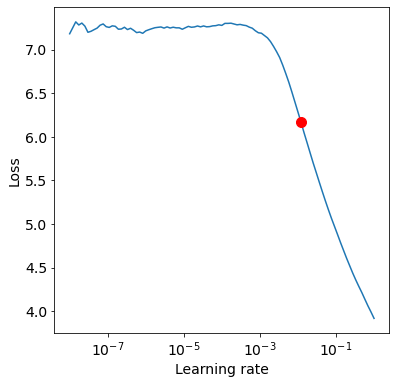

In [24]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [25]:
new_lr = lr_finder.suggestion()

In [26]:
new_lr

0.012022644346174132

In [27]:
model.hparams.learning_rate = new_lr

In [28]:
model.learning_rate = new_lr

In [29]:
model.learning_rate

0.012022644346174132

In [30]:
trainer.fit(model, jet_dm)

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sangeonpark/metricembedder/e57fb5d95b8e40b2b3dbd6047afd652c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [20] : (0.90470951795578, 8.024327278137207)
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (579.39 KB)
COMET INFO:  

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [35]:
predictloader = jet_dm.predict_dataloader()

In [ ]:
for temp in predictloader:
    print(temp[0][0])

In [31]:
a = trainer.predict(model, jet_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: Set model graph ignored; already called. Call with overwrite=True to replace graph definition
/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 16836it [00:00, ?it/s]

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:172: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sangeonpark/metricembedder/8cb0ed6dbfcf44aa9292b55d036bb8b0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3368]      : (0.3155609667301178, 6.736972808837891)
COMET INFO:     train_loss [336] : (0.3233000934123993, 0.6970011591911316)
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompre

In [32]:
label = np.array([])
embedding = np.empty((0,2))
for batch in a:
    #print(batch[0].shape)
    #print(batch[1].shape)
    embedding = np.vstack((embedding, batch[0].cpu().numpy()))
    label = np.concatenate([label, batch[1].cpu().numpy()])
    #print(batch[0], batch[1])

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})

In [34]:
embedding[label==0]

array([[-0.22315396,  0.09061615],
       [-0.22437407,  0.09401114],
       [-0.22451885,  0.09416744],
       ...,
       [-0.22504283,  0.09483705],
       [-0.22664753,  0.09595235],
       [-0.22406104,  0.09345891]])

In [35]:
embedding[label==1]

array([[-0.2099808 , -0.10883722],
       [-0.20999119, -0.10887729],
       [-0.21001141, -0.10893048],
       ...,
       [-0.21001771, -0.10894562],
       [-0.20990837, -0.10864811],
       [-0.21001519, -0.10893853]])

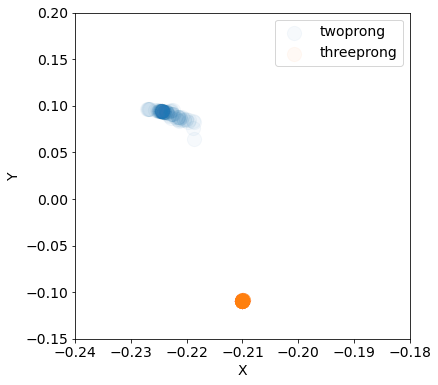

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(embedding[label==0][:100,0],embedding[label==0][:100,1],s=200,alpha=0.04,label='twoprong')
ax.scatter(embedding[label==1][:100,0],embedding[label==1][:100,1],s=200,alpha=0.04,label='threeprong')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([-0.24,-0.18])
ax.set_ylim([-0.15,0.2])
ax.legend()
fig.savefig(f'../figures/jet_embedding_pair_2.png')

(-100.0, 100.0)

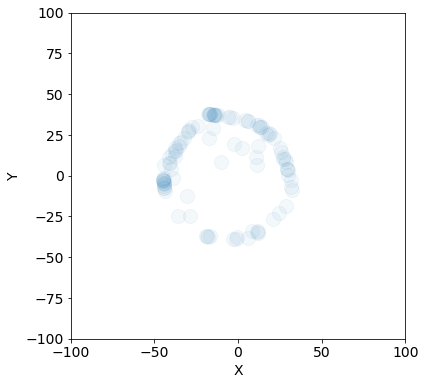

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.scatter(embedding[label==0][:1000,0],embedding[label==0][:1000,1],s=200,alpha=0.05)
ax.scatter(embedding[label==1][:100,0],embedding[label==1][:100,1],s=200,alpha=0.05)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
#fig.savefig(f'{path}/{name}.png')

In [42]:
embedding[label==0]

array([[34.16513062, -1.49830151],
       [34.1387825 , -1.53783011],
       [34.53158569, -0.93025315],
       ...,
       [34.1339798 , -1.54286742],
       [30.40222168,  5.07749081],
       [34.23294067, -1.4946003 ]])

In [43]:
embedding[label==1]

array([[34.15142822, -1.52005196],
       [34.01434708, -1.64321101],
       [34.10200119, -1.60349095],
       ...,
       [34.09588623, -1.59495401],
       [34.40365982, -1.46968496],
       [34.20943451, -1.48509216]])

In [41]:
label

array([0., 0., 0., ..., 1., 1., 1.])

In [ ]:
experiment.end()

In [ ]:
import tensorboard

In [11]:
%load_ext tensorboard

In [17]:
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6007 (pid 2019324), started 0:02:41 ago. (Use '!kill 2019324' to kill it.)